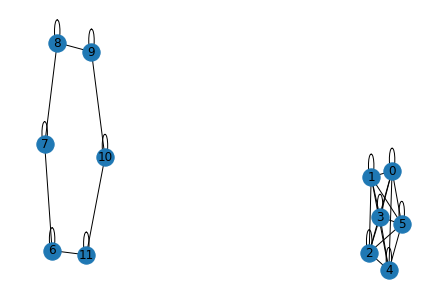

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-colorblind')
import scipy.stats as sps
import networkx as nx
import time
from Dist_UCB1_Small_Graphs import Dist_UCB1
import os
from multiprocess import Pool

n_runs = 100
T = 10000
G1 = nx.complete_graph(6)
G2 = nx.cycle_graph([6,7,8,9,10,11])
G = nx.compose(G1,G2)
N = G.number_of_nodes()

nodes = list(G.nodes)
for i in nodes:
    G.add_edge(i,i)
nx.draw(G, with_labels=True)

rwd_means = [.2, .3, .4, .5, .6]
betas = [1, 1, 1, 0.01, 0.01, 0.01, 1, 1, 1, 0.01, 0.01, 0.01]
seeds = [i for i in range(n_runs)]

In [8]:
def worker(job_runs, seeds, betas, T, N, G):
    regrets_dist_ucb1 = np.zeros((len(job_runs), N, T))
    for run in job_runs:
        start_run_t = time.time()
        
        sd = 0.1
        kl_distributions = [sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))]
        for i in range(len(rwd_means)):
            kl_distributions[i].random_state = np.random.RandomState(seed=seeds[run])
        distributions = [[sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))] for n in range(N)]
        for n in range(N):
            for i in range(len(rwd_means)):
                distributions[n][i].random_state = np.random.RandomState(seed=seeds[run])
        
        #sigmas = [1, 1 0.01, 0.01]
        distucb1 = Dist_UCB1(T, distributions, G, beta=betas)
        distucb1.run()
        regrets_dist_ucb1[run-job_runs[0], :, :] = distucb1.regrets
        
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return regrets_dist_ucb1

In [9]:
regrets_dist_ucb1 = np.zeros((n_runs, N, T))
init_time = time.time()
cpus = os.cpu_count()
init_time = time.time()

pool = Pool() # no need to pass in cpus, does os.cpu_count() by default
jobs = list(range(n_runs))
job_size = n_runs // cpus
job_chunks = [(jobs[i:i + job_size], seeds, betas, T, N, G) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker, job_chunks)
pool.close()
pool.join()
regrets_dist_ucb1_unconcat = [result for result in results]
np.concatenate(regrets_dist_ucb1_unconcat, out=regrets_dist_ucb1)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_ucb1 = np.mean(regrets_dist_ucb1, axis=0)
std_regrets_over_all_runs_dist_ucb1 = np.std(regrets_dist_ucb1, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_UCB1_Small_Graphs.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_UCB1_Small_Graphs.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)


finished run 0 in 63.572272062301636sec
finished run 50 in 64.2233452796936sec
finished run 1 in 70.3788959980011sec
finished run 51 in 69.87691760063171sec
finished run 52 in 64.85820007324219sec
finished run 2 in 65.7914662361145sec
finished run 53 in 65.63746237754822sec
finished run 3 in 65.37912917137146sec
finished run 54 in 65.14345383644104sec
finished run 4 in 65.24300837516785sec
finished run 55 in 67.2468090057373sec
finished run 5 in 67.84260368347168sec
finished run 56 in 66.20594191551208sec
finished run 6 in 67.30110907554626sec
finished run 57 in 66.87045240402222sec
finished run 7 in 65.9737160205841sec
finished run 58 in 65.18000888824463sec
finished run 8 in 65.78639125823975sec
finished run 59 in 65.95243620872498sec
finished run 9 in 65.87461376190186sec
finished run 60 in 65.60753870010376sec
finished run 10 in 65.53624606132507sec
finished run 61 in 65.50870728492737sec
finished run 11 in 65.7207100391388sec
finished run 62 in 65.93536949157715sec
finished run 12

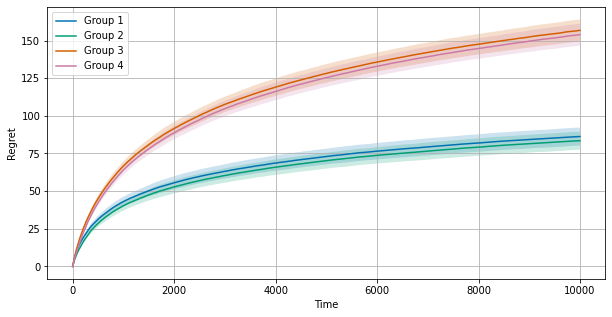

In [25]:
plt.figure(figsize=(10,5))
#plt.subplot(122)
neighbors = [1, 2, 2, 1]
#for sig in range(len(sigmas)):
#    plt.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig], )#label=r"$\varsigma=$" + str(sigmas[sig]) + ", " + r"$|\scr N_i|=$" + str(neighbors[sig]))
#    plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig]-std_regrets_over_all_runs_dist_kl_ucb[sig], mean_regrets_over_all_runs_dist_kl_ucb[sig]+std_regrets_over_all_runs_dist_kl_ucb[sig],alpha=.2)
#plt.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[0], label="Agent 1")
#plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[0]-std_regrets_over_all_runs_dist_ucb1[0], mean_regrets_over_all_runs_dist_ucb1[0]+std_regrets_over_all_runs_dist_ucb1[0],alpha=.2)
#plt.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[1], label="Agent 2")
#plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[1]-std_regrets_over_all_runs_dist_ucb1[1], mean_regrets_over_all_runs_dist_ucb1[1]+std_regrets_over_all_runs_dist_ucb1[1],alpha=.2)
#plt.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[2], label="Agent 3")
#plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[2]-std_regrets_over_all_runs_dist_ucb1[2], mean_regrets_over_all_runs_dist_ucb1[2]+std_regrets_over_all_runs_dist_ucb1[2],alpha=.2)
#plt.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[3], label="Agent 4")
#plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[3]-std_regrets_over_all_runs_dist_ucb1[3], mean_regrets_over_all_runs_dist_ucb1[3]+std_regrets_over_all_runs_dist_ucb1[3],alpha=.2)
avg_3_1_regret = np.mean(mean_regrets_over_all_runs_dist_ucb1[0:3], axis=0)
avg_3_001_regret = np.mean(mean_regrets_over_all_runs_dist_ucb1[3:6], axis=0)
avg_6_1_regret = np.mean(mean_regrets_over_all_runs_dist_ucb1[6:9], axis=0)
avg_6_001_regret = np.mean(mean_regrets_over_all_runs_dist_ucb1[9:12], axis=0)
std_3_1_regret = np.mean(std_regrets_over_all_runs_dist_ucb1[0:3], axis=0)
std_3_001_regret = np.mean(std_regrets_over_all_runs_dist_ucb1[3:6], axis=0)
std_6_1_regret = np.mean(std_regrets_over_all_runs_dist_ucb1[6:9], axis=0)
std_6_001_regret = np.mean(std_regrets_over_all_runs_dist_ucb1[9:12], axis=0)

plt.plot(time_axis, avg_3_1_regret, label="Group 1")
plt.fill_between(time_axis, avg_3_1_regret-std_3_1_regret, avg_3_1_regret+std_3_1_regret,alpha=.2)
plt.plot(time_axis, avg_3_001_regret, label="Group 2")
plt.fill_between(time_axis, avg_3_001_regret-std_3_001_regret, avg_3_001_regret+std_3_001_regret,alpha=.2)
plt.plot(time_axis, avg_6_1_regret, label="Group 3")
plt.fill_between(time_axis, avg_6_1_regret-std_6_1_regret, avg_6_1_regret+std_6_1_regret,alpha=.2)
plt.plot(time_axis, avg_6_001_regret, label="Group 4")
plt.fill_between(time_axis, avg_6_001_regret-std_6_001_regret, avg_6_001_regret+std_6_001_regret,alpha=.2)
plt.xlabel("Time")
plt.ylabel("Regret")
#plt.ylim([80,180])
plt.legend()
plt.grid()
#plt.subplot(121)
#nx.draw(G, with_labels=True)
plt.savefig("dist_UCB1_small_graphs_all_together_N12.pdf", bbox_inches='tight')

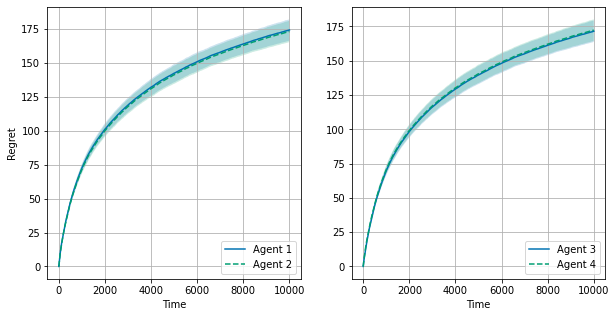

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
neighbors = [1, 2, 2, 1]
ax1.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[0], label="Agent 1")
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[0]-std_regrets_over_all_runs_dist_ucb1[0], mean_regrets_over_all_runs_dist_ucb1[0]+std_regrets_over_all_runs_dist_ucb1[0],alpha=.2)
ax1.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[1], linestyle="--", label="Agent 2")
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[1]-std_regrets_over_all_runs_dist_ucb1[1], mean_regrets_over_all_runs_dist_ucb1[1]+std_regrets_over_all_runs_dist_ucb1[1],alpha=.2)
ax2.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[2], label="Agent 3")
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[2]-std_regrets_over_all_runs_dist_ucb1[2], mean_regrets_over_all_runs_dist_ucb1[2]+std_regrets_over_all_runs_dist_ucb1[2],alpha=.2)
ax2.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[3], linestyle="--", label="Agent 4")
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[3]-std_regrets_over_all_runs_dist_ucb1[3], mean_regrets_over_all_runs_dist_ucb1[3]+std_regrets_over_all_runs_dist_ucb1[3],alpha=.2)
ax1.set_xlabel("Time")
ax1.set_ylabel("Regret")
ax1.legend(loc="lower right")
ax1.grid()
ax2.set_xlabel("Time")
ax2.legend(loc="lower right")
ax2.grid()
plt.savefig("dist_UCB1_small_graphs_N12.pdf", bbox_inches='tight')